In [182]:
%tensorflow_version 2.x
import tensorflow as tf
import json
import requests
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [183]:
df = pd.read_excel('/content/HNX30.xlsx')
df

,Time,Last,Open,High,Low
0,2012-08-01,116.53,130.95,138.31,108.63
1,2012-09-01,103.31,116.53,118.20,101.83
2,2012-10-01,97.57,103.29,108.04,96.01
3,2012-11-01,92.35,96.76,97.74,90.22
4,2012-12-01,107.77,92.48,108.04,91.25
...,...,...,...,...,...
136,2023-12-01,494.88,478.27,510.54,469.49
137,2024-01-01,487.34,493.47,504.51,473.08
138,2024-02-01,505.31,487.74,507.83,484.66
139,2024-03-01,533.82,505.71,541.83,492.86


In [184]:
df.describe()

,Time,Last,Open,High,Low
count,141,141.000000,141.000000,141.000000,141.000000
mean,2018-06-01 08:51:03.829787136,265.801206,262.771702,281.841206,245.303688
min,2012-08-01 00:00:00,92.350000,92.480000,97.740000,90.220000
25%,2015-07-01 00:00:00,154.770000,153.050000,159.630000,144.990000
50%,2018-06-01 00:00:00,189.340000,188.810000,194.240000,180.740000
75%,2021-05-01 00:00:00,354.320000,346.210000,384.730000,320.460000
max,2024-04-01 00:00:00,823.440000,823.440000,892.180000,786.140000
std,NaN,170.922589,169.840230,184.792107,153.575652


In [185]:
df['Time'] = pd.to_datetime(df['Time'], format='%d/%m/%Y')
df.index = df['Time']
df.drop(["Time"], axis='columns', inplace=True)
df.sort_index(ascending=True, inplace=True)
df.rename(columns={'Last': 'Close'}, inplace=True)
df['Close'] = pd.to_numeric(df['Close'], errors='coerce')
df['Open'] = pd.to_numeric(df['Open'], errors='coerce')
df['High'] = pd.to_numeric(df['High'], errors='coerce')
df['Low'] = pd.to_numeric(df['Low'], errors='coerce')

In [186]:
df

,Close,Open,High,Low
Time,,,,
2012-08-01,116.53,130.95,138.31,108.63
2012-09-01,103.31,116.53,118.20,101.83
2012-10-01,97.57,103.29,108.04,96.01
2012-11-01,92.35,96.76,97.74,90.22
2012-12-01,107.77,92.48,108.04,91.25
...,...,...,...,...
2023-12-01,494.88,478.27,510.54,469.49
2024-01-01,487.34,493.47,504.51,473.08
2024-02-01,505.31,487.74,507.83,484.66


In [187]:
print(df.dtypes)

Close    float64
Open     float64
High     float64
Low      float64
dtype: object


In [188]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 141 entries, 2012-08-01 to 2024-04-01
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   141 non-null    float64
 1   Open    141 non-null    float64
 2   High    141 non-null    float64
 3   Low     141 non-null    float64
dtypes: float64(4)
memory usage: 5.5 KB


In [189]:
df['Close'] = df['Close'].fillna(method='ffill', inplace=False)

In [190]:
df.shape[0]-df.shape[0]*0.2

112.8

In [191]:
df.index[113]

Timestamp('2022-01-01 00:00:00')

In [192]:
target_col = 'Close'

In [193]:
def train_test_split(df, test_size=0.2):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data

In [194]:
train, test = train_test_split(df, test_size=0.2)

In [195]:
def line_plot(line1, line2, label1=None, label2=None, lw=2, title='', figsize=(12, 6)):
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('HNX30', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16)
    plt.show()

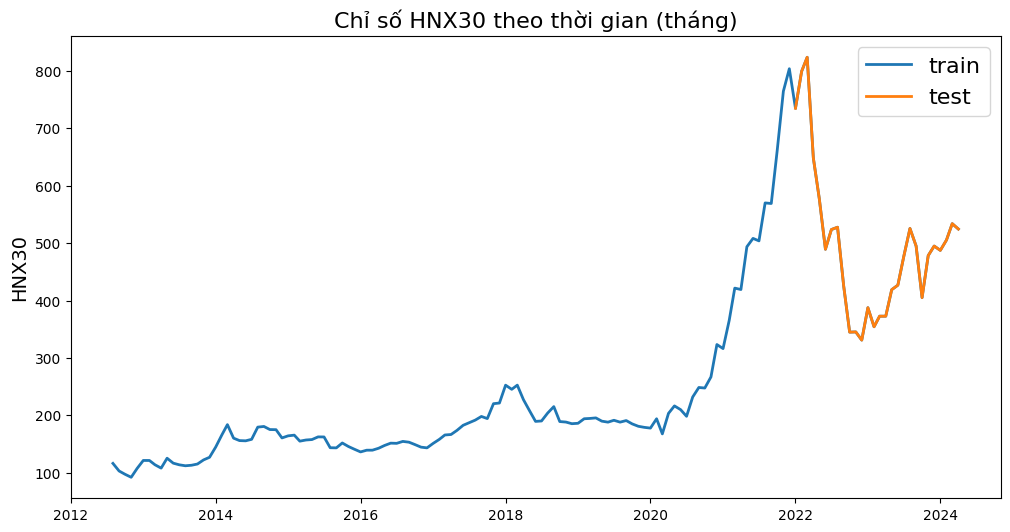

In [196]:
line_plot(df.Close, test.Close, 'train', 'test', title='Chỉ số HNX30 theo thời gian (tháng)')

In [197]:
def normalise_zero_base(df):
    return df / df.iloc[0] - 1

def normalise_min_max(df):
    return (df - df.min()) / (df.max() - df.min())

In [198]:
np.random.seed(42)
window_len = 1
test_size = 0.2
zero_base = True
lstm_neurons = 100
epochs = 50
batch_size = 25
loss = 'mse'
dropout = 0.2
optimizer = 'adam'
learning_rate=1e-6

In [199]:
def extract_window_data(df, window_len= window_len, zero_base=True):
    window_data = []
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)

In [200]:
def prepare_data(df, target_col, window_len= window_len, zero_base=True, test_size=0.2):
    train_data, test_data = train_test_split(df, test_size=test_size)
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)
    y_train = train_data[target_col][window_len:].values
    y_test = test_data[target_col][window_len:].values
    if zero_base:
        y_train = y_train / train_data[target_col][:-window_len].values - 1
        y_test = y_test / test_data[target_col][:-window_len].values - 1

    return train_data, test_data, X_train, X_test, y_train, y_test

In [201]:
def build_lstm_model(input_data, output_size, neurons, activ_func, dropout, loss, optimizer):
    model = Sequential()

    # First LSTM layer - define input_shape and set return_sequences=True
    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2]), return_sequences=True))
    model.add(Dropout(dropout))

    # Subsequent LSTM layers - only set return_sequences=True for all but the last LSTM layer
    model.add(LSTM(neurons, return_sequences=True))
    model.add(Dropout(dropout))

    model.add(LSTM(neurons, return_sequences=True))
    model.add(Dropout(dropout))

    # Last LSTM layer - do not set return_sequences as it should be False by default
    model.add(LSTM(neurons))
    model.add(Dropout(dropout))

    # Output layer
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    # Compile the model
    model.compile(loss=loss, optimizer=optimizer)

    return model

In [202]:
train, test, X_train, X_test, y_train, y_test = prepare_data(df, target_col, window_len=window_len, zero_base=zero_base, test_size=test_size)

In [203]:
print(train.shape[0])
print(test.shape[0])

113
28


In [204]:
print(len(X_train))
print(len(X_test))

112
27


In [205]:
model = build_lstm_model(X_train, output_size=1, neurons=lstm_neurons, activ_func='linear', dropout=dropout, loss='mse', optimizer=optimizer)
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/50
5/5 [==============================] - 69s 548ms/step - loss: 0.0056 - val_loss: 0.0126
Epoch 2/50
5/5 [==============================] - 0s 23ms/step - loss: 0.0055 - val_loss: 0.0130
Epoch 3/50
5/5 [==============================] - 0s 21ms/step - loss: 0.0055 - val_loss: 0.0131
Epoch 4/50
5/5 [==============================] - 0s 21ms/step - loss: 0.0055 - val_loss: 0.0127
Epoch 5/50
5/5 [==============================] - 0s 21ms/step - loss: 0.0054 - val_loss: 0.0125
Epoch 6/50
5/5 [==============================] - 0s 18ms/step - loss: 0.0055 - val_loss: 0.0124
Epoch 7/50
5/5 [==============================] - 0s 16ms/step - loss: 0.0055 - val_loss: 0.0125
Epoch 8/50
5/5 [==============================] - 0s 21ms/step - loss: 0.0055 - val_loss: 0.0125
Epoch 9/50
5/5 [==============================] - 0s 29ms/step - loss: 0.0054 - val_loss: 0.0125
Epoch 10/50
5/5 [==============================] - 0s 30ms/step - loss: 0.0055 - val_loss: 0.0127
Epoch 11/50
5/5 [==========

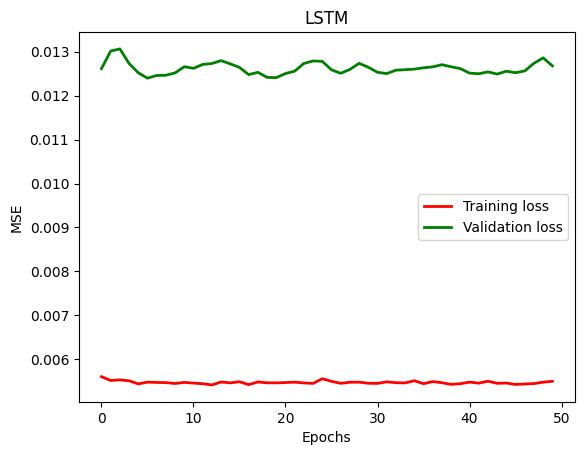

In [206]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'],'r',linewidth=2, label='Training loss')
plt.plot(history.history['val_loss'], 'g',linewidth=2, label='Validation loss')
plt.title('LSTM')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.show()

In [207]:
targets = test[target_col][window_len:]
preds = model.predict(X_test).squeeze()

1/1 [==============================] - 2s 2s/step


In [208]:
def line_plot1(line1, line2, line3, label1=None, label2=None, label3=None, title='HNX30 Prediction', lw=1, figsize=(12,6)):
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.plot(line3, label=label3, linewidth=lw)
    ax.set_ylabel('HNX30', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16)
    plt.show()

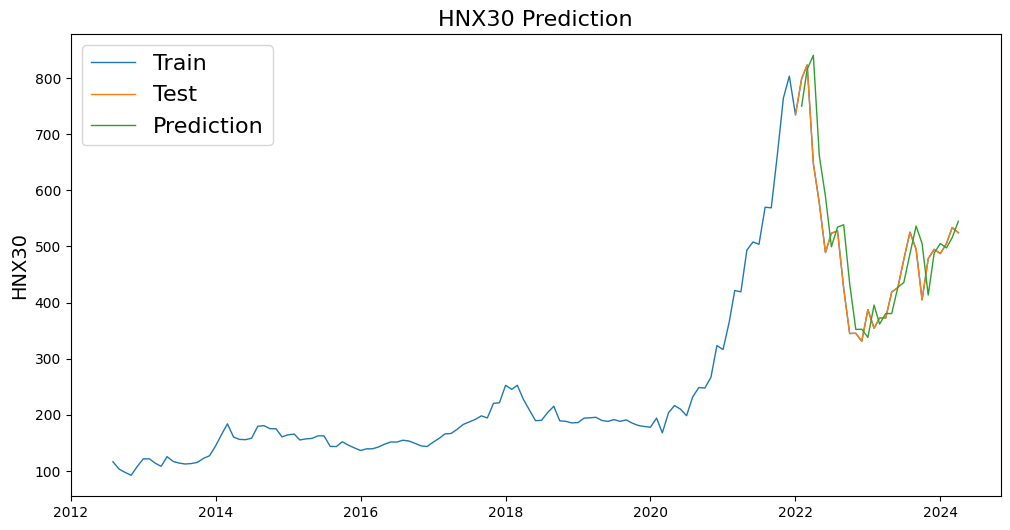

In [209]:
preds = test[target_col].values[:-window_len] * (preds+1)
preds = pd.Series(index=targets.index, data=preds)
line_plot1(df["Close"], test['Close'], preds, 'Train', 'Test', 'Prediction')

In [210]:
targets

Time
2022-02-01    798.96
2022-03-01    823.44
2022-04-01    648.26
2022-05-01    577.34
2022-06-01    489.24
2022-07-01    523.59
2022-08-01    527.62
2022-09-01    425.17
2022-10-01    344.99
2022-11-01    345.36
2022-12-01    331.09
2023-01-01    387.57
2023-02-01    354.32
2023-03-01    372.76
2023-04-01    372.74
2023-05-01    418.90
2023-06-01    426.77
2023-07-01    477.02
2023-08-01    525.46
2023-09-01    494.89
2023-10-01    405.02
2023-11-01    478.27
2023-12-01    494.88
2024-01-01    487.34
2024-02-01    505.31
2024-03-01    533.82
2024-04-01    524.45
Name: Close, dtype: float64

In [211]:
preds

Time
2022-02-01    750.033518
2022-03-01    815.712371
2022-04-01    840.705661
2022-05-01    661.852535
2022-06-01    589.445505
2022-07-01    499.498248
2022-08-01    534.568490
2022-09-01    538.682989
2022-10-01    434.084846
2022-11-01    352.223654
2022-12-01    352.601412
2023-01-01    338.032203
2023-02-01    395.696460
2023-03-01    361.749283
2023-04-01    380.575928
2023-05-01    380.555509
2023-06-01    427.683379
2023-07-01    435.718395
2023-08-01    487.022023
2023-09-01    536.477699
2023-10-01    505.266716
2023-11-01    413.512347
2023-12-01    488.298232
2024-01-01    505.256506
2024-02-01    497.558410
2024-03-01    515.905200
2024-04-01    545.012989
dtype: float64

In [212]:
from sklearn.metrics import mean_absolute_error
MAE = mean_absolute_error(preds, targets)
MAE

44.51551973537165

In [213]:
from sklearn.metrics import mean_squared_error
MSE = mean_squared_error(preds, targets)
MSE

3880.65750470258

In [214]:
from sklearn.metrics import r2_score
R2 = r2_score(preds, targets)
R2

0.7762988116894163

In [215]:
mape = np.sum(np.abs((targets - preds) / targets))*(100 / len(targets))
rmse = np.sqrt(mean_squared_error(targets, preds))

print(f"MAPE: {mape:.2f}%")
print(f"RMSE: {rmse}")

MAPE: 9.41%
RMSE: 62.294923586939085
